# Support Vector Machine (SVM) no trading em tempo real: Como se beneficiar dos humores do Mercado com ações da Tesla?


** Storytelling**

O algoritmo de Support Vector Machine é uma multidiscilplinar ferramenta computacional utilizada na recomendação de mídia com base no interesse de usuários do Instagram ou Netflix, apuração de diagnósticos médicos como diabetes e câncer ou o reconhecimento de padrão de spam em emails no Google.

No caso do mercado financeiro, e se pudéssemos prever e testar a performance de uma estratégia de trading diário minuto a minuto das ações da Tesla (TSLA), entre vender, manter ou comprar?

Veremos que o SVM é formado a partir das dimensões baixas de um Maximal Margin Classifier (MMC), e que pela complexidade dos dados e necessidade de separá-los ( melhor classificação entre vender, manter, comprar), um limite de decisão linear é necessário. Aí entra o Support Vector Classifier (SVC). A transição dimensional é feita pelo Kernel, um artifício que apresenta os dados somente aos pares de observações entre os dados originais e os transforma em dimensões mais altas. Esses dados acomodados em alta dimensão, num limite de decisão não-linear é chamado Support Vector Machine (SVM).

Dito isso, além dos comumentemente modelados preços de abertura, alta, baixa e preço ajustado, o nosso modelo receberá indicadores da análise técnica como o RSI (índice de força relativa), SMA (média móvel simples), entre outros.

A modelagem algoritmica definiu o signal, ou critério de investimento, sendo esse o retorno por minuto com base na decisão de vender (-1), manter (0) ou comprar (1) o ativo.

Em seguida, foram definidos os melhores hiperparâmetros para C, Gamma e Kernel e então, pudemos calcular a estratégia com base no SVM e fazer o backtesting da estratégia.

Por fim, concluímos que o backtesting do dia mostrou que as ações da Tesla tiveram um retorno final acumulado de 0,14%, ao passo que a estratégia de trading SVM alcançou um retorno acumulado de 1,09%.

Ademais, na matriz de confusão da estratégia, a Precisão (42% e 53% respectivamente), o Recall (53% e 40% respectivamente) e o F1 Score (47% e 46% respectivamente) das estratégias de vender e manter o ativo mostraram-se com os valores mais altos que a estratégia de compra das ações da Tesla.


# 1) Importar bibliotecas

In [ ]:

# Manipulação e fonte de dados
import pandas as pd
import numpy as np
import yfinance as yf

# Caminho para download do Talib (lib de indicadores de trading)
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib                                                  # https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab


# Libs de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Libs de visualização
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML

# Outras
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4432    0  4432    0     0   9022      0 --:--:-- --:--:-- --:--:--  9026
100  517k  100  517k    0     0   359k      0  0:00:01  0:00:01 --:--:-- 1007k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4384    0  4384    0     0  10276      0 --:--:-- --:--:-- --:--:-- 10266
100  392k  100  392k    0     0   276k      0  0:00:01  0:00:01 --:--:--  975k


# 2) Web scraping e Cleaning Data

In [ ]:
# Web scraping da cotação

cotacao = yf.download('TSLA',start='2024-02-26', end='2024-02-27', period='1d', interval='1m')      # No trade diário (período de 1 dia), extrair cotação no intervalo de 1 minuto
cotacao = cotacao.drop(cotacao[cotacao['Volume'] == 0].index)                                       # Extrair volumes iguais a zero
cotacao.tail(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-02-26 15:57:00-05:00,199.762497,199.768494,199.470001,199.530106,199.530106,391908
2024-02-26 15:58:00-05:00,199.529999,199.539993,199.360001,199.404999,199.404999,434762
2024-02-26 15:59:00-05:00,199.404999,199.449997,199.350006,199.350006,199.350006,552360


In [ ]:
cotacao.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390 entries, 2024-02-26 09:30:00-05:00 to 2024-02-26 15:59:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       390 non-null    float64
 1   High       390 non-null    float64
 2   Low        390 non-null    float64
 3   Close      390 non-null    float64
 4   Adj Close  390 non-null    float64
 5   Volume     390 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 21.3 KB


In [ ]:
# Gráfico do movimento diário em Candlestick

fig = go.Figure()

fig.add_trace(go.Candlestick(x=cotacao.index,
                open = cotacao['Open'],
                high = cotacao['High'],
                low  = cotacao['Low'],
                close = cotacao['Close'], name = 'market data'))

fig.update_layout(
    title='Movimento diário',
    yaxis_title = 'Cotação da Ação')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons= list([
            dict(count=1, label='30m', step='minute', stepmode='backward'),
            dict(count=6, label='90m', step='minute', stepmode='backward'),
            dict(count=1, label='HTM', step='hour', stepmode='todate'),
            dict(step='all')
                            ])

    )

)

fig.show()


# 3) Modelagem Financeira

A adição desses indicadores objetiva tornar o modelo mais robusto que somente os indicadores padrão OHLC.


## 3.1) RSI

In [ ]:
# Adicionar coluna RSI (Relative strengh index) para comparação à cotação atual

# O RSI é um indicador de momentum, que mensura a velocidade e a magnitude das mudanças recentes do ativo com o objetivo
# de avaliar a sub ou sobrevalorização de preço.
# RSI = 100 - (100 / (1 + média do ganho / média da perda))
# A média é o percentual no período

#Como pode ver no gráfico abaixo, o RSI é um signal que pode auxiliar na previsão do comportamento do ativo, tendências
# ou reversões de preço e negociação de volume.

n= 14 # Period of intradays = número de barras de preços recentes que o indicador considera para o seu cálculo. Para fins de negociação intradiária, o período padrão é 14, refletindo a análise das últimas 14 barras de preços.
cotacao['RSI'] = talib.RSI(np.array(cotacao['Close'].shift(1)), timeperiod=n)
cotacao

,Open,High,Low,Close,Adj Close,Volume,RSI
Datetime,,,,,,,
2024-02-26 09:30:00-05:00,194.070801,194.169998,194.070602,194.070602,194.070602,2313839,NaN
2024-02-26 09:31:00-05:00,194.070007,194.740005,193.750000,194.470001,194.470001,695967,NaN
2024-02-26 09:32:00-05:00,194.485001,194.709900,194.039993,194.709900,194.709900,481989,NaN
2024-02-26 09:33:00-05:00,194.701996,195.169998,194.460007,195.059998,195.059998,864847,NaN
2024-02-26 09:34:00-05:00,195.079895,195.149994,194.309494,194.479996,194.479996,520046,NaN
...,...,...,...,...,...,...,...
2024-02-26 15:55:00-05:00,199.839996,199.895004,199.649994,199.769302,199.769302,299254,62.313283
2024-02-26 15:56:00-05:00,199.764999,199.789993,199.680099,199.759995,199.759995,267100,59.422562
2024-02-26 15:57:00-05:00,199.762497,199.768494,199.470001,199.530106,199.530106,391908,59.059766


In [ ]:
# Correlação Cotação da Ação X RSI

# Como se trata de um gráfico de cotação diária, compare ambos os gráficos ao longo do dia para retirar conclusões.

fig = make_subplots(rows=2, cols=1, row_heights=[0.7, 0.3])
fig.add_trace(go.Candlestick(x=cotacao.index,
                open = cotacao['Open'],
                high = cotacao['High'],
                low  = cotacao['Low'],
                close = cotacao['Close'], name = 'Correlação Cotação da ação'),
                row=1, col=1)

fig.update_layout(
    title='Cotação da ação X RSI')

fig.update_xaxes(
    rangeslider_visible = False)

fig.add_trace(go.Scatter(x=cotacao.index,
                y=cotacao['RSI'], name='RSI da ação', line=dict(color='royalblue', width=1.2)),
                row=2, col=1)

fig.show()

## 3.2) SMA, Corr, SAR Parabólico e ADX

In [ ]:
# Coluna SMA (Simple Moving Average)
cotacao['SMA'] = cotacao['Close'].shift(1).rolling(window=n).mean()

# Coluna Correlação
cotacao['Corr'] = cotacao['Close'].shift(1).rolling(window=n).corr(cotacao['SMA'].shift(1))

# Adicionar a coluna SAR Parabólico
# Do mesmo criador do RSI, ATR e ADX (J. Welles Wilder), o SAR (Stop and Reverse) parabólico é um indicador de sobreposição
# para determinar a direção (tendência) do preço de um ativo e fornecer potenciais sinais de entrada e saída, os chamados
# pontos de reversão. O nome parabólico vem da visualização gráfica do sar se assemelhar a uma parábola.
# Logo, se valor de mercado > valor encontrado no SAR = tendência de alta.
#       Se valor de mercado < valor encontrado no SAR = tendência de baixa.
cotacao['SAR_Prbc'] = talib.SAR(np.array(cotacao['High'].shift(1)), np.array(cotacao['Low'].shift(1)), 0.2, 0.2)

# Coluna ADX (average directional index)
# É um indicador de momentum que objetiva determinar a força da direção (tendência) do preço e as sinalizações das
# movimentações futuras dos preços.
# Logo, se valor encontrado no ADX > 25 = tendência de alta
#       se valor encontrado no ADX < 20 = tendência de baixa
cotacao['ADX'] = talib.ADX(np.array(cotacao['High'].shift(1)), np.array(cotacao['Low'].shift(1)),
                           np.array(cotacao['Open']), timeperiod=n)

cotacao.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,ADX
Datetime,,,,,,,,,,,
2024-02-26 15:57:00-05:00,199.762497,199.768494,199.470001,199.530106,199.530106,391908,59.059766,199.542537,0.174139,199.514999,15.990542
2024-02-26 15:58:00-05:00,199.529999,199.539993,199.360001,199.404999,199.404999,434762,50.808831,199.552044,0.052684,199.895004,15.311654
2024-02-26 15:59:00-05:00,199.404999,199.449997,199.350006,199.350006,199.350006,552360,46.963617,199.547494,-0.124121,199.810004,14.300633


In [ ]:
# Colunas HLC com delay de 1 minuto
cotacao['High_min_ant'] = cotacao['High'].shift(1)
cotacao['Low_min_ant'] = cotacao['Low'].shift(1)
cotacao['Close_min_ant'] = cotacao['Close'].shift(1)

cotacao.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,ADX,High_min_ant,Low_min_ant,Close_min_ant
Datetime,,,,,,,,,,,,,,
2024-02-26 09:30:00-05:00,194.070801,194.169998,194.070602,194.070602,194.070602,2313839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26 09:31:00-05:00,194.070007,194.740005,193.750000,194.470001,194.470001,695967,NaN,NaN,NaN,NaN,NaN,194.169998,194.070602,194.070602
2024-02-26 09:32:00-05:00,194.485001,194.709900,194.039993,194.709900,194.709900,481989,NaN,NaN,NaN,194.740005,NaN,194.740005,193.750000,194.470001


## 3.3) Indicadores de Sensibilidade

In [ ]:
# Colunas de Indicadores de Sensibilidade

# Open - Open do dia anterior
cotacao['OO'] = cotacao['Open'] - cotacao['Open'].shift(1)

# Open Close - Close do minuto anterior
cotacao['OC'] = cotacao['Open'] - cotacao['Close_min_ant']
cotacao

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,ADX,High_min_ant,Low_min_ant,Close_min_ant,OO,OC
Datetime,,,,,,,,,,,,,,,,
2024-02-26 09:30:00-05:00,194.070801,194.169998,194.070602,194.070602,194.070602,2313839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-26 09:31:00-05:00,194.070007,194.740005,193.750000,194.470001,194.470001,695967,NaN,NaN,NaN,NaN,NaN,194.169998,194.070602,194.070602,-0.000793,-0.000595
2024-02-26 09:32:00-05:00,194.485001,194.709900,194.039993,194.709900,194.709900,481989,NaN,NaN,NaN,194.740005,NaN,194.740005,193.750000,194.470001,0.414993,0.014999
2024-02-26 09:33:00-05:00,194.701996,195.169998,194.460007,195.059998,195.059998,864847,NaN,NaN,NaN,194.740005,NaN,194.709900,194.039993,194.709900,0.216995,-0.007904
2024-02-26 09:34:00-05:00,195.079895,195.149994,194.309494,194.479996,194.479996,520046,NaN,NaN,NaN,193.750000,NaN,195.169998,194.460007,195.059998,0.377899,0.019897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26 15:55:00-05:00,199.839996,199.895004,199.649994,199.769302,199.769302,299254,62.313283,199.516881,-0.140530,199.309998,14.804909,199.860001,199.729996,199.845001,0.099991,-0.005005
2024-02-26 15:56:00-05:00,199.764999,199.789993,199.680099,199.759995,199.759995,267100,59.422562,199.533974,-0.035571,199.419998,15.419682,199.895004,199.649994,199.769302,-0.074997,-0.004303
2024-02-26 15:57:00-05:00,199.762497,199.768494,199.470001,199.530106,199.530106,391908,59.059766,199.542537,0.174139,199.514999,15.990542,199.789993,199.680099,199.759995,-0.002502,0.002502


## 3.4) Retornos Intradiários

In [ ]:
# Colunas de retornos intradiários

# Fornecerá 14 retornos para negociação intradiária
cotacao['Ret'] = cotacao['Open'].pct_change()

for i in range(1,n):
  cotacao['return%i' % i] = cotacao['Ret'].shift(1)

## 3.5) Signal da Correlação




In [ ]:
# Converter a coluna Correlação para Signal

# O gatilho será o sinal da correlação. 1 para corr positiva e -1 para corr negativa.
cotacao.loc[cotacao['Corr'] <  0, 'Corr'] = -1
cotacao.loc[cotacao['Corr'] >  0, 'Corr'] = 1
cotacao = cotacao.dropna()
print('Correlações nulas: ', cotacao.loc[cotacao['Corr'] ==  0].sum().sum()) # Checar correlação nula. Como não há, as condições acima são o bastante
cotacao

Correlações nulas:  0.0


,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,...,return4,return5,return6,return7,return8,return9,return10,return11,return12,return13
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26 09:58:00-05:00,196.485001,196.940002,196.369995,196.684097,196.684097,296309,58.605891,196.887772,1.0,197.024994,...,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142
2024-02-26 09:59:00-05:00,196.720001,196.899994,196.000000,196.440002,196.440002,371958,60.623788,196.925207,-1.0,197.024994,...,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651
2024-02-26 10:00:00-05:00,196.419998,196.679993,196.139999,196.475006,196.475006,322406,56.680673,196.899600,-1.0,196.940002,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196
2024-02-26 10:01:00-05:00,196.469101,196.800003,196.279999,196.660004,196.660004,315672,57.111475,196.873530,-1.0,196.940002,...,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525,-0.001525
2024-02-26 10:02:00-05:00,196.634903,197.500000,196.610001,197.059906,197.059906,614985,59.409010,196.857815,-1.0,196.899994,...,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250,0.000250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26 15:55:00-05:00,199.839996,199.895004,199.649994,199.769302,199.769302,299254,62.313283,199.516881,-1.0,199.309998,...,0.000952,0.000952,0.000952,0.000952,0.000952,0.000952,0.000952,0.000952,0.000952,0.000952
2024-02-26 15:56:00-05:00,199.764999,199.789993,199.680099,199.759995,199.759995,267100,59.422562,199.533974,-1.0,199.419998,...,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501
2024-02-26 15:57:00-05:00,199.762497,199.768494,199.470001,199.530106,199.530106,391908,59.059766,199.542537,1.0,199.514999,...,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375,-0.000375


# 4) Modelagem Algoritmica (ML)

In [ ]:
# 70% de dados para treino

t = .7
split = int(t*len(cotacao))
print('Total: ', len(cotacao))
print('Treino: ',split)
print('Teste: ', len(cotacao) - split)

Total:  362
Treino:  253
Teste:  109


##4.1) Definir os Signals de Output

In [ ]:
# Cria a coluna Signal (retorno por minuto)

cotacao['Signal'] = 0  # Representa os retornos no quantil 66%, entre -0.03% e 0.12%
cotacao.loc[cotacao['Ret'] > cotacao['Ret'][:split].quantile(q= 0.66), 'Signal'] =  1  # Representa os retornos > que 66% (acima de 0.12%) dos retornos nos dados de treino receberão um signal positivo
cotacao.loc[cotacao['Ret'] < cotacao['Ret'][:split].quantile(q= 0.34), 'Signal'] = -1  # Representa os retornos < que 34% (abaixo de 0.03%) dos retornos nos dados de treino receberão um signal negativo
cotacao.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,...,return5,return6,return7,return8,return9,return10,return11,return12,return13,Signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26 09:58:00-05:00,196.485001,196.940002,196.369995,196.684097,196.684097,296309,58.605891,196.887772,1.0,197.024994,...,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-1
2024-02-26 09:59:00-05:00,196.720001,196.899994,196.000000,196.440002,196.440002,371958,60.623788,196.925207,-1.0,197.024994,...,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,1
2024-02-26 10:00:00-05:00,196.419998,196.679993,196.139999,196.475006,196.475006,322406,56.680673,196.899600,-1.0,196.940002,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,-1


## 4.2) Selecionar variáveis preditoras e vetor alvo

In [ ]:
# Input (Predictors)

X = cotacao.drop(['Close', 'Signal', 'High', 'Low', 'Volume', 'Ret'], axis=1)
X.head(3)

,Open,Adj Close,RSI,SMA,Corr,SAR_Prbc,ADX,High_min_ant,Low_min_ant,Close_min_ant,...,return4,return5,return6,return7,return8,return9,return10,return11,return12,return13
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26 09:58:00-05:00,196.485001,196.684097,58.605891,196.887772,1.0,197.024994,24.815488,196.837997,196.330002,196.499893,...,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142
2024-02-26 09:59:00-05:00,196.720001,196.440002,60.623788,196.925207,-1.0,197.024994,23.689475,196.940002,196.369995,196.684097,...,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651
2024-02-26 10:00:00-05:00,196.419998,196.475006,56.680673,196.899600,-1.0,196.940002,22.114899,196.899994,196.000000,196.440002,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196


In [ ]:
X.columns

Index(['Open', 'Adj Close', 'RSI', 'SMA', 'Corr', 'SAR_Prbc', 'ADX',
       'High_min_ant', 'Low_min_ant', 'Close_min_ant', 'OO', 'OC', 'return1',
       'return2', 'return3', 'return4', 'return5', 'return6', 'return7',
       'return8', 'return9', 'return10', 'return11', 'return12', 'return13'],
      dtype='object')

In [ ]:
# Vetor alvo (o que se quer prever)

y = cotacao['Signal']
y

Datetime
2024-02-26 09:58:00-05:00   -1
2024-02-26 09:59:00-05:00    1
2024-02-26 10:00:00-05:00   -1
2024-02-26 10:01:00-05:00    0
2024-02-26 10:02:00-05:00    1
                            ..
2024-02-26 15:55:00-05:00    0
2024-02-26 15:56:00-05:00    0
2024-02-26 15:57:00-05:00    0
2024-02-26 15:58:00-05:00   -1
2024-02-26 15:59:00-05:00   -1
Name: Signal, Length: 362, dtype: int64

## 4.3) Definir Hiperparâmetros

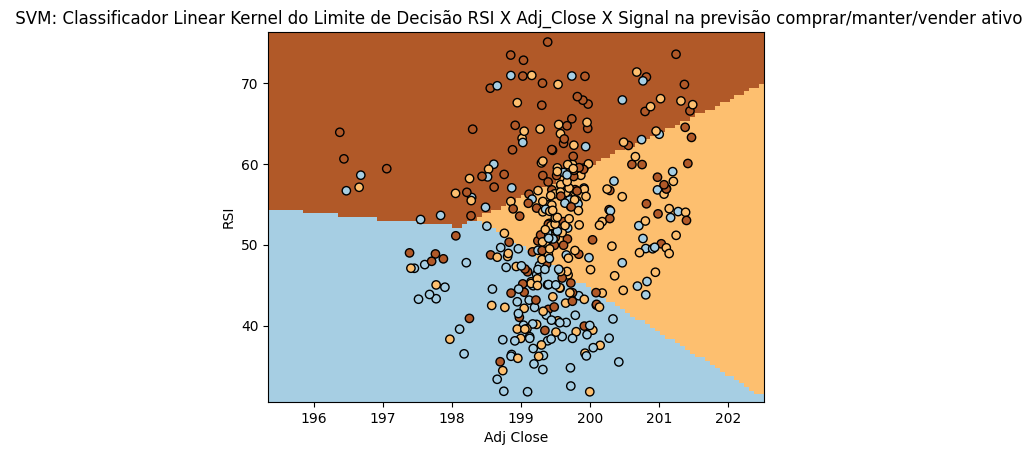

In [ ]:
# Limite do Hiperparâmetro via Kernel

# https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py


A = X[['Adj Close', 'RSI']]   # Essas 2 features servem como exemplo. Outras relações podem ser visualizadas.
b = y


def my_kernel(A, b):
    """
    Customização do hiperparâmetro kernel:

                 (rows  0)
    k(A, b) = X  (    ) Y.T
                 (0  cols)
    """
    rows = len(X[['Adj Close', 'RSI']])
    cols = len(X[['Adj Close', 'RSI']].columns)
    M = np.eye(cols)
    return np.dot(np.dot(A, M), b.T)


h = 0.02  # step size in the mesh

# Criar uma instância para classificar e fitar os dados
clf = svm.SVC(kernel='linear')            # 'linear' e my_kernel são o mesmo classificador. Outra opção é o 'rbf'
clf.fit(A, b)

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    A,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

# Plotar Adj Close RSI e dados de treino (inclusive)
plt.scatter(A['Adj Close'], A['RSI'], c=b, cmap=plt.cm.Paired, edgecolors="k")
plt.title(" SVM: Classificador Linear Kernel do Limite de Decisão RSI X Adj_Close X Signal na previsão comprar/manter/vender ativo")
plt.axis("tight")
plt.show()

In [ ]:
# Definir Hiperparâmetros do SVM

# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#:~:text=Intuitively%2C%20the%20gamma%20parameter%20defines,the%20model%20as%20support%20vectors.

# Uma vez que um modelo de ML é um modelo matemático-estatístico que aprende padrões de dados de forma implícita,
# os parâmetros que não possuem a capacidade de aprender desta forma (dependem da intuição humana ou ajuste antes do
# treino ) são chamados de Hiperparâmetros. No sklearn são 15, porém aqui lidaremos com: C, Gamma e Kernel

# Os hiperparâmetros definem o melhor hiperplano para o modelo.
# Hiperplano é o melhor limite de decisão do SVC que busca separar os dados em categorias (no caso, prever: venda = -1,
# manter = 0 e comprar = 1) via maximização euclidiana da distância entre os pontos da amostra.

# Limite de decisão é a região (que pode ser visualizada e portanto melhor compreendida ao puxar o módulo
# DecisionBoundaryDisplay.from_estimator) no espaço-problema onde o output do classificador é ambiguo (ver nesse plot).

# Sobre os hiperplanos individualmente:

# O hiperparâmetro C     https://stackabuse.com/understanding-svm-hyperparameters/
# Trata-se de um hiperparâmetro de regulação (controle de erro), que regula o trade off entre erros de dados de treino
# e a margem, pois penaliza o modelo nas desclassificações durante o treinamento. Assim, quanto menor o c, maiores as
# penalidades de  desclassificações nos dados de treino, o que pode resultar em margem mais larga entre os dados
# ( ou seja: parâmetro c e margem são inversamente proporcionais)

# O hiperparâmetro Kernel seleciona o tipo de limite que separará os dados em categorias. O kernel 'linear' usa
# um hiperparâmeteo linear (no caso de dados bidimensionais como RSI e Adj_Close) e os classificadores rbf e poly
# utilizam hiperplanos não lineares.

# O hiperparâmetro Gamma define o raio de influência de um único exemplo de treino. Como o parâmetro c, ele é
# inversamente proporcional à margem.
# Valores muito baixos para Gamma deixam o modelo muito restrito, não conseguindo capturar a complexidade ou “formato”
# dos dados. Em valores muito altos, o raio da área de influência dos vetores de suporte inclui apenas o próprio vetor
# de suporte e nenhuma regularização c será capaz de evitar o sobreajuste. Já para valores intermediários, bons modelos
# podem ser encontrados na diagonal de c e gamma. Para ilustrar, observe o limite de decisão acim e as 2 formas de
# definir os melhores hiperparâmetros para C e Gamma (via GridSearchCV e StratifiedShuffleSplit e via rcv.best_params_))
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#:~:text=Intuitively%2C%20the%20gamma%20parameter%20defines,the%20model%20as%20support%20vectors.


# Criar parâmetros
c = [.1, 10, 100, 1000]
g = [1e-2, 1e-1, 1e0]

# Inicializar parâmetros
parametros = {'svc__C': c,
              'svc__gamma': g,
              'svc__kernel': ['rbf']
              }

passos = [('scaler', StandardScaler()), ('svc', SVC())]
pipeline = Pipeline(passos)

# Utilizar o RandomizedSearchCV para ajustar dados e trazer score sob os parâmetros personalizados.
# Como o GridSearchCV, o rcv é um selecionador de modelo do scikitlearn que busca os melhores parâmetros, a diferença é
# que ele testa somente os valores passados numa lista
rcv = RandomizedSearchCV(pipeline, parametros, cv=TimeSeriesSplit(n_splits=5))

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.get_params

In [ ]:
# Observe que um split de 70/30 aumenta a acurácia do modelo em relação a um train/test de 80/20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state= 42)

In [ ]:
# 1 de 2 formas de definir os melhores hiperparâmetros para C e Gamma

# GridSearchCV é um selecionador de modelo do scikitlearn que busca os melhores parâmetros, ajustando os dados e
# trazendo um score (pontuação). https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# StratifiedShuffleSplit é um tipo de validação cruzada, resultante da fusão entre StratifiedKFold e ShuffleSplit. Seu
# objetivo é fornecer um índice treino/teste para os dados splitados. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

# from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
# from sklearn.svm import SVC

C_hiperps = [.1, 10, 100, 1000]
gamma_hiperps = [1e-2, 1e-1, 1e0]
param_grid = dict(gamma=gamma_hiperps, C=C_hiperps)
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, refit=True, verbose=3, cv=cv)
grid.fit(X, y)

print(
    "Os melhores hiperparêmetros são %s com um score de %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .................C=0.1, gamma=0.01;, score=0.376 total time=   0.0s
[CV 2/3] END .................C=0.1, gamma=0.01;, score=0.349 total time=   0.0s
[CV 3/3] END .................C=0.1, gamma=0.01;, score=0.385 total time=   0.0s
[CV 1/3] END ..................C=0.1, gamma=0.1;, score=0.367 total time=   0.0s
[CV 2/3] END ..................C=0.1, gamma=0.1;, score=0.367 total time=   0.0s
[CV 3/3] END ..................C=0.1, gamma=0.1;, score=0.367 total time=   0.0s
[CV 1/3] END ..................C=0.1, gamma=1.0;, score=0.367 total time=   0.0s
[CV 2/3] END ..................C=0.1, gamma=1.0;, score=0.367 total time=   0.0s
[CV 3/3] END ..................C=0.1, gamma=1.0;, score=0.367 total time=   0.0s
[CV 1/3] END ..................C=10, gamma=0.01;, score=0.532 total time=   0.0s
[CV 2/3] END ..................C=10, gamma=0.01;, score=0.468 total time=   0.0s
[CV 3/3] END ..................C=10, gamma=0.01;

In [ ]:
# 2 de 2 formas de definir hiperparâmetros:
# Com os melhores parâmetros de C e Gamma passados, o RandomizedSearchCV treina os dados

rcv.fit(X_train, y_train)         # Utilizar o selecionador de modelo train test split deixa o modelo mais elegante e evitar erro de chained assigmnent

best_c = rcv.best_params_['svc__C']
best_gamma = rcv.best_params_['svc__gamma']
best_kernel = rcv.best_params_['svc__kernel']


## 4.4) Criar o SVC e treinar o modelo

In [ ]:
# Criar o classificador Support Vector Classifier com os melhores hiperparâmetros

cls = SVC(C=best_c, gamma=best_gamma,  kernel=best_kernel )

In [ ]:
# Treinar os dados

ss = StandardScaler()
cls.fit(ss.fit_transform(X_train), y_train)

SVC(C=10, gamma=0.01)

## 4.5) Estabelecimento e previsão dos Signals

In [ ]:
# Signal são gatilhos estipulados para comprar ou vender um ativo de acordo com um critério

# Sinais do trading. Sinal = 1, comprar ação; Sinal = -1, vender; Sinal = 0, mantê-la

y_predict = cls.predict(ss.transform(X_test))
cotacao['Pred_Signal'] = 0

In [ ]:
y_predict

array([ 0, -1,  1,  1, -1,  0,  0,  1,  1,  1,  0,  1, -1,  1,  1,  0,  0,
        1,  0,  1,  1,  0,  1,  0, -1, -1, -1, -1, -1,  0, -1,  1,  0,  0,
       -1,  0,  0,  1,  1, -1,  0,  0, -1,  0, -1, -1,  1,  0,  1,  1, -1,
        0,  0,  0, -1,  1, -1,  0,  0,  1, -1, -1,  1,  1,  0,  0, -1, -1,
       -1,  1,  0,  1,  0, -1,  1,  1,  0,  1,  0, -1, -1, -1,  1,  0, -1,
       -1,  0,  0,  1, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0, -1,  0, -1,
        0,  1,  1, -1,  0,  0,  0])

In [ ]:
# Salvar dados previstos aos dados de treino
cotacao.iloc[:split, cotacao.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss.transform(X_train)).tolist())

# Salvar os dados previstos aos dados de teste
cotacao.iloc[split:, cotacao.columns.get_loc('Pred_Signal')] = y_predict

In [ ]:
cotacao.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,...,return6,return7,return8,return9,return10,return11,return12,return13,Signal,Pred_Signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26 09:58:00-05:00,196.485001,196.940002,196.369995,196.684097,196.684097,296309,58.605891,196.887772,1.0,197.024994,...,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-1,-1
2024-02-26 09:59:00-05:00,196.720001,196.899994,196.000000,196.440002,196.440002,371958,60.623788,196.925207,-1.0,197.024994,...,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,1,0
2024-02-26 10:00:00-05:00,196.419998,196.679993,196.139999,196.475006,196.475006,322406,56.680673,196.899600,-1.0,196.940002,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,-1,-1


In [ ]:
# É o retorno da estratégia. Trata-se do trading automatizado, ou seja, o retorno atual vezes o signal (gatilhos) dos
# dados previstos

cotacao['Ret1'] = cotacao['Ret'] * cotacao['Pred_Signal']
cotacao.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR_Prbc,...,return7,return8,return9,return10,return11,return12,return13,Signal,Pred_Signal,Ret1
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-26 09:58:00-05:00,196.485001,196.940002,196.369995,196.684097,196.684097,296309,58.605891,196.887772,1.0,197.024994,...,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-0.000142,-1,-1,0.001651
2024-02-26 09:59:00-05:00,196.720001,196.899994,196.000000,196.440002,196.440002,371958,60.623788,196.925207,-1.0,197.024994,...,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,-0.001651,1,0,0.000000
2024-02-26 10:00:00-05:00,196.419998,196.679993,196.139999,196.475006,196.475006,322406,56.680673,196.899600,-1.0,196.940002,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,-1,-1,0.001525


## 4.6) Backtest e avaliação de performance da Estratégia

In [ ]:
# Backtest da estratégia em Support Vector Machine

fig = go.Figure()

fig.add_trace(go.Scatter(x=cotacao.index[split:],                                   # Retorno acumulado da ação em 1 dia
                         y=(cotacao['Ret'][split:] +1).cumprod(),
                         line=dict(color='royalblue', width=.8),
                         name='Retorno da Ação'))
fig.add_trace(go.Scatter(x=cotacao.index[split:],                                   # Retorno acumulado da estratégia em 1 dia
                         y=(cotacao['Ret1'][split:] +1).cumprod(),
                         line=dict(color='orange', width=.8),
                         name='Retorno da Estratégia'))

fig.update_layout(
    title='Backtest do trade diário com base no Support Vector Machine: Retornos acumulados da Ação X Estratégia',
    yaxis_title = 'Retorno % da Ação')

fig.show()


In [ ]:
# Matriz de confusão

cm = confusion_matrix(y[split:], y_predict)
cm

array([[16,  9,  5],
       [13, 21, 18],
       [ 9, 10,  8]])

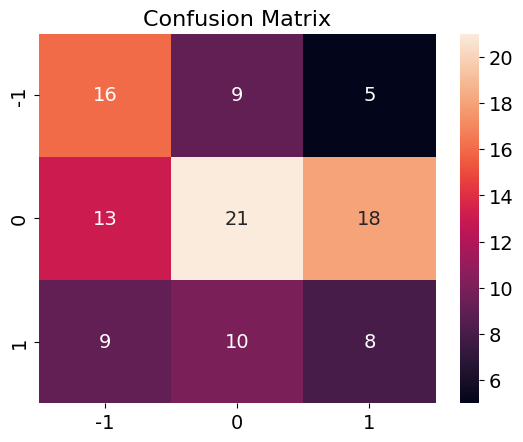

In [ ]:
# Plotar o mapa de calor da matriz de confusão

# A diagonal principal são as previsões corretas

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predict Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams.update({'font.size':14})

ax=plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.xaxis.set_ticklabels(['-1', '0', '1'])
ax.yaxis.set_ticklabels(['-1', '0', '1'])
plt.show()


In [ ]:
# Reporte de classificação

cr = classification_report(y[split:], y_predict)
print(cr)

              precision    recall  f1-score   support

          -1       0.42      0.53      0.47        30
           0       0.53      0.40      0.46        52
           1       0.26      0.30      0.28        27

    accuracy                           0.41       109
   macro avg       0.40      0.41      0.40       109
weighted avg       0.43      0.41      0.42       109



### 4.6.1) Precisão da Estratégia

Mostra o quanto o modelo é **correto ao prever** a variável alvo.

É a razão de verdadeiros positivos de uma classe (vender, manter ou comprar) pela soma das previsões positivas dessa classe.

Precisão = TP / (TP + FP)

Responde à pergunta: De todos os casos cuja previsão é compra (ou manutenção ou venda), quantos na realidade o modelo deve exercer corretamente a compra (ou manutenção ou venda)?

In [ ]:
# Precisão da previsão vender ação (-1)
prec_vender = round(cm[0][0] / (cm[0][0] + cm[1][0] + cm[2][0]), 2) *100
print( 'A precisão da previsão vender ação (-1) foi acertada pelo algoritmo em', prec_vender, '% dos casos')

A precisão da previsão vender ação (-1) foi acertada pelo algoritmo em 42.0 % dos casos


In [ ]:
# Precisão da previsão manter ação (0)
prec_manter = round(cm[1][1] / (cm[0][1] + cm[1][1] + cm[2][1]), 2) *100
print( 'A precisão da previsão manter ação (0) foi acertada pelo algoritmo em', prec_manter, '% dos casos')

A precisão da previsão manter ação (0) foi acertada pelo algoritmo em 52.0 % dos casos


In [ ]:
# Precisão da previsão comprar ação (1)
prec_comprar = round(cm[2][2] / (cm[0][2] + cm[1][2] + cm[2][2]), 2) *100
print( 'A precisão da previsão comprar ação (1) foi acertada pelo algoritmo em', prec_comprar, '% dos casos')

A precisão da previsão comprar ação (1) foi acertada pelo algoritmo em 26.0 % dos casos


### 4.6.2) Média Ponderada da Estratégia

In [ ]:
# Média Ponderada da Estratégia

# É a média ponderada do número de verdadeiros positivos pela quantidade total de classes (vender, manter e comprar)
# Na média, esse foi o número de previsões corretas do algoritmo
media_pond = round((cm[0][0] + cm[1][1] + cm[2][2]) / (cm[0][0] + cm[0][1] + cm[0][2] + cm[1][0] + cm[1][1] + cm[1][2] + cm[2][0] + cm[2][1] + cm[2][2]),2)*100
print( 'A média Ponderada da Estratégia foi', media_pond, '% de acertos')


A média Ponderada da Estratégia foi 41.0 % de acertos


### 4.6.3) Recall (Sensibilidade) da Estratégia
Mostra o quanto o modelo é **bom em identificar** todos os dados numa variável alvo.

É a razão de verdadeiros positivos de uma classe (vender, manter ou comprar) pela soma de todas as previsões dessa classe (enquanto a precisão tem em seu denominador todas as previsões positivas).

Precisão = TP / (TP + FN)

Responde à pergunta: De todos os casos identificados como compra (ou manutenção ou venda), quantos na realidade o modelo identifica como compra (ou manutenção ou venda)?

In [ ]:
# Recall da previsão vender ação (-1)
recall_vender = round(cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2]), 2) *100
print( 'O Recall da previsão vender ação (-1) foi acertada pelo algoritmo em', recall_vender, '% dos casos')

O Recall da previsão vender ação (-1) foi acertada pelo algoritmo em 53.0 % dos casos


In [ ]:
# Recall da previsão manter ação (0)
recall_manter = round(cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2]), 2) *100
print( 'O Recall da previsão manter ação (0) foi acertada pelo algoritmo em', recall_manter, '% dos casos')

O Recall da previsão manter ação (0) foi acertada pelo algoritmo em 40.0 % dos casos


In [ ]:
# Recall da previsão comprar ação (1)
recall_comprar = round(cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2]), 2) *100
print( 'O Recall da previsão comprar ação (1) foi acertada pelo algoritmo em', recall_comprar, '% dos casos')

O Recall da previsão comprar ação (1) foi acertada pelo algoritmo em 30.0 % dos casos


### 4.6.4) F1 Score da Estratégia

Uma vez que a Precisão e Recall são métricas que devem ser analizadas juntas, porém o aumento de uma causa redução na outra (no estilo trade off viés e variância), o F1 Score surge como uma média ponderada entre precisão e recall.

Quanto maior, maior a harmonia entre entre precisão e recall.

https://medium.com/nerd-for-tech/confusion-matrix-demystify-the-confusion-5d7f4801ad4f

In [ ]:
# F1 Score da previsão vender ação (-1)
f1_vender =  round(2 * (prec_vender * recall_vender) / (prec_vender + recall_vender),2)
print( 'O F1 score da previsão vender ação (-1) foi acertada pelo algoritmo em', f1_vender, '% dos casos')

O F1 score da previsão vender ação (-1) foi acertada pelo algoritmo em 46.86 % dos casos


In [ ]:
# F1 Score da previsão manter ação (0)
f1_manter =  round(2 * (prec_manter * recall_manter) / (prec_manter + recall_manter),2)
print( 'F1 Score da previsão manter ação (0) foi acertada pelo algoritmo em', f1_manter, '% dos casos')

F1 Score da previsão manter ação (0) foi acertada pelo algoritmo em 45.22 % dos casos


In [ ]:
# F1 Score da previsão comprar ação (1)
f1_comprar =  round(2 * (prec_comprar * recall_comprar) / (prec_comprar + recall_comprar),2)
print( 'F1 Score da previsão manter ação (0) foi acertada pelo algoritmo em', f1_comprar, '% dos casos')

F1 Score da previsão manter ação (0) foi acertada pelo algoritmo em 27.86 % dos casos


# 5) Conclusão

O algoritmo de Support Vector Machine utiliza a técnica Kernel, um poderoso artifício que permite a solução de dados em problemas de classificação não-linear ao mapear os dados em relativa baixa dimensão e movê-los para altas dimensões  e assim, encontrar um melhor classificador que os separa (o chamado limite de decisão).

A regressão logística conta somente com o limite de decisão linear.

Desta forma, o algoritmo em SVM visa a melhor forma de fitar as variáveis da cotação ( OHLC, RSI, SAR, retornos...), encontrar os melhores hiperparâmetros de C, Gamma e Kernel e por fim, mapear o limite de decisão entre venda, manutenção e compra do ativo.

As métricas de performance avaliam o algoritmo e consequentemente a estratégia.

O backtesting do dia mostrou que as ações da Tesla tiveram um retorno final acumulado de 0,14%, ao passo que a estratégia de trading SVM alcançou um retorno acumulado de 1,09%.

Por fim, a Precisão (42% e 53% respectivamente), o Recall (53% e 40% respectivamente) e o F1 Score (47% e 46% respectivamente) das estratégias de vender e manter o ativo mostraram-se com os valores mais altos que a estratégia de compra das ações da Tesla.